In [1]:
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import os 
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from umap import UMAP

os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/patchcore.yaml'
cfg = parser(True,default_setting, model_setting)
cfg.DATASET.anomaly_ratio = 0.0
cfg.MODEL.params.sampling_ratio = 0.1

trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

testloader = DataLoader(
        dataset     = testset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = False 
    )    
accelerator = Accelerator()

model  = __import__('models').__dict__[cfg.MODEL.method](
            backbone = cfg.MODEL.backbone,
            **cfg.MODEL.params
            )



 Experiment Name : Baseline-identity-sampling_ratio_0.1-anomaly_ratio_0.0



In [2]:
featureloader = accelerator.prepare(model.get_feature_loader(trainloader))
features = [] 
for feat, target in featureloader:
    features.append(feat.detach().cpu().numpy())            
features = np.vstack(features)

model.core.featuresampler.percentage = cfg.MODEL.params.pslabel_sampling_ratio
proxy, _ = model.core.featuresampler.run(features)
model.core.featuresampler.percentage = cfg.MODEL.params.sampling_ratio

#! 가장 기본 distance matrix 계산 방법 

if cfg.DATASET.pseudo_label == 'coreset':
    # distmat = torch.matmul(torch.Tensor(features),torch.Tensor(proxy).T)
    proxy_label = [] 
    for feat,_ in featureloader:
        proxy_label.append(torch.matmul(feat,torch.Tensor(proxy).to(feat.device).T).argmax(dim=1))
    proxy_label = torch.concat(proxy_label)
    
elif cfg.DATASET.pseudo_label == 'normalize_coreset':
    proxy = nn.functional.normalize(torch.Tensor(proxy),dim=1)
    #distmat = torch.matmul(torch.Tensor(features),proxy.T)
    proxy_label = [] 
    for feat,_ in featureloader:
        proxy_label.append(torch.matmul(feat,proxy.T.to(feat.device)).argmax(dim=1))
    proxy_label = torch.concat(proxy_label)
else:
    raise NotImplementedError        


featureloader.dataset.labels = proxy_label

model.set_criterion(proxy)
model = accelerator.prepare(model)

Subsampling...: 100%|██████████| 4704/4704 [00:00<00:00, 5241.34it/s]


In [3]:
for idx, (feat, target) in enumerate(featureloader):
    
    #! augmentation 
    if cfg.DATASET.embed_augemtation:
        feat = feat + torch.randn(feat.shape).to(feat.device)        
    
    # predict
    outputs = model(feat.to(accelerator.device)) # outputs = [z,w]
    loss   = model.criterion([outputs, target],reduction=False)
    break 

In [1]:
import pandas as pd 
with open('cutmixup_concat.txt','r') as f: 
    cutmixup_concat = pd.DataFrame([eval(d) for d in f.readlines()])
with open('mixup_conjconcat.txt','r') as f: 
    mixup_conjconcat = pd.DataFrame([eval(d) for d in f.readlines()])
    

In [3]:
cutmixup_concat['method'] = 'cutmixup_concat'
mixup_conjconcat['method'] = 'mixup_conjconcat'

In [4]:
df = pd.concat([cutmixup_concat,mixup_conjconcat])

<AxesSubplot:xlabel='pertur', ylabel='test_r_mean'>

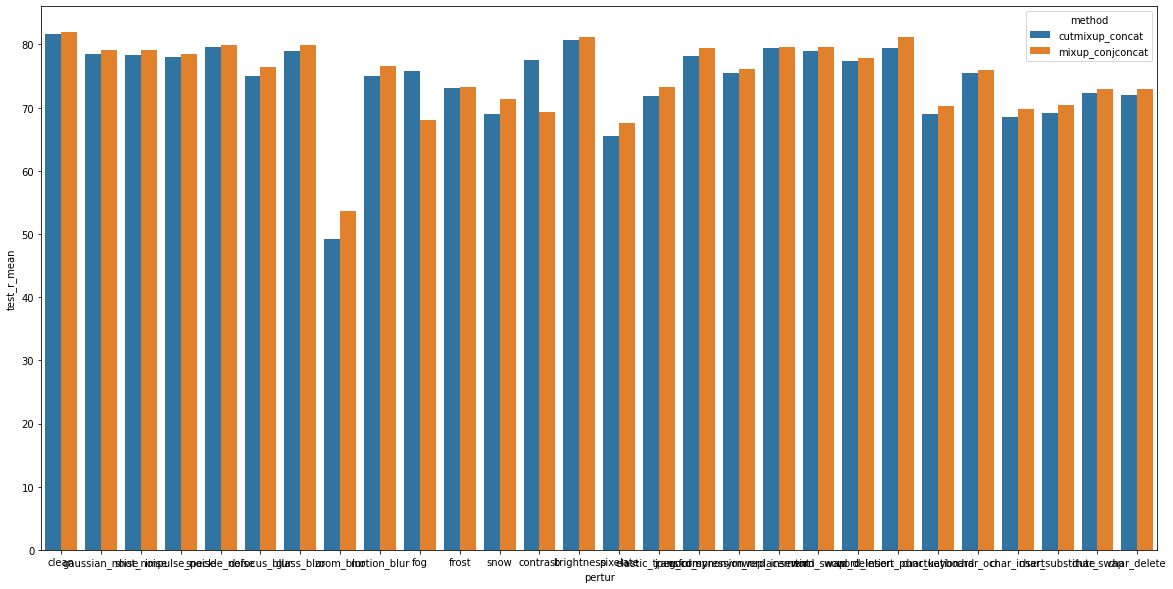

In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,10))
sns.barplot(
    x = 'pertur',
    y = 'test_r_mean',
    hue = 'method',
    data = df 
)